In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
np.random.seed(1)

In [2]:
def simulate_one_step(abd,interaction_df,noise_scaler):       ## Linear, maybe turn it as non-linear?
    noise = -1 + 2 * np.random.random((len(abd),1)).squeeze()
    noise = abd * noise * noise_scaler
    temp_abd = abd @ interaction_df + noise
    temp_abd = temp_abd.map(lambda x:max(1e-5,x))
    temp_abd = temp_abd/sum(temp_abd)
    return np.array(temp_abd),noise

def simulate_one_example(interaction_df,steps,noise_scaler):
    init_abd = np.array([np.random.random() for i in range(interaction_df.shape[0])])
    init_abd = init_abd / sum(init_abd)       # dict(zip(bac_names,init_abd))
    snapshot_list = []
    noise_list = []
    for i in range(steps):
        temp_abd,temp_noise = simulate_one_step(init_abd,interaction_df,noise_scaler)
        snapshot_list.append(temp_abd)
        noise_list.append(temp_noise)
    return init_abd, np.array(snapshot_list), np.array(noise_list)

def plot_allu(mtx):
    plot_data = {}
    (step,n) = mtx.shape
    for i in range(n):
        plot_data['bac{}'.format(i+1)] = mtx[:,i]
    plt.figure(figsize=(10,3))
    plt.stackplot([i for i in range(step)], plot_data.values(),labels=plot_data.keys(), alpha=0.8)
    plt.legend(loc='best')
    plt.show()
    print(" Max: {}, Min: {}".format(mtx.max(),mtx.min()))


def plot_scatter(mtx):
    (step,n) = mtx.shape
    plt.figure(figsize=(10,3))
    for i in range(n):
        x = [i] * step
        y = mtx[:,i]
        plt.scatter(x, y)

def plot_box(mtx):
    plt.figure(figsize=(10,3))
    plt.boxplot(mtx)

## Fake Data

Assume we have a set of bacterias and their interactions are already known. 

We will init them with random abundances, and model their bahaviors. We may addin noises, and hope the system stay diverse (and perhaps never to be stable). Snapshots will be made during this process.

In [3]:
n = 9

bac_names = ["bac{}".format(i+1) for i in range(n)]
interaction_df = pd.DataFrame(-1 + 2 * np.random.random((n,n)),index=bac_names,columns=bac_names)
for i in range(n):
    interaction_df.iloc[i,i] = 1
    if interaction_df.iloc[i,i]<0:
        interaction_df.iloc[i,i] = interaction_df.iloc[i,i]*(-1)

interaction_df

,bac1,bac2,bac3,bac4,bac5,bac6,bac7,bac8,bac9
bac1,1.000000,0.440649,-0.999771,-0.395335,-0.706488,-0.815323,-0.627480,-0.308879,-0.206465
bac2,0.077633,1.000000,0.370439,-0.591096,0.756235,-0.945225,0.340935,-0.165390,0.117380
bac3,-0.719226,-0.603797,1.000000,0.936523,-0.373152,0.384645,0.752778,0.789213,-0.829912
bac4,-0.921890,-0.660339,0.756285,1.000000,-0.157785,0.915779,0.066331,0.383754,-0.368969
bac5,0.373002,0.669251,-0.963423,0.500289,1.000000,0.496331,-0.439112,0.578559,-0.793548
bac6,-0.104213,0.817191,-0.412772,-0.424449,-0.739943,1.000000,0.357671,-0.576744,-0.468907
bac7,-0.016854,-0.893275,0.148235,-0.706543,0.178611,0.399517,1.000000,-0.171888,0.388800
bac8,-0.171641,-0.900093,0.071793,0.327589,0.029778,0.889190,0.173110,1.000000,-0.725051
bac9,-0.721447,0.614783,-0.204646,-0.669292,0.855017,-0.304468,0.501624,0.451996,1.000000


## Simulate

we repeat the process for 300 times:

    1. random init abdance
    2. 100 steps 



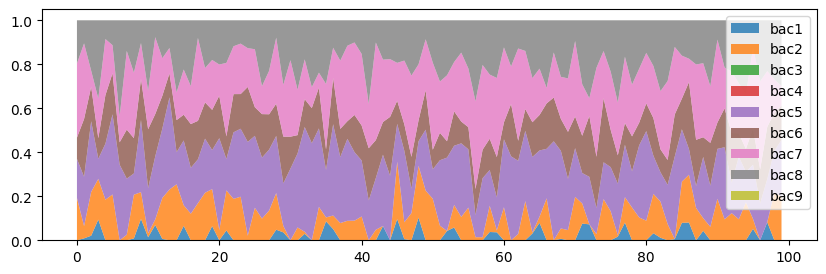

 Max: 0.4762251614685503, Min: 7.874982830115071e-06


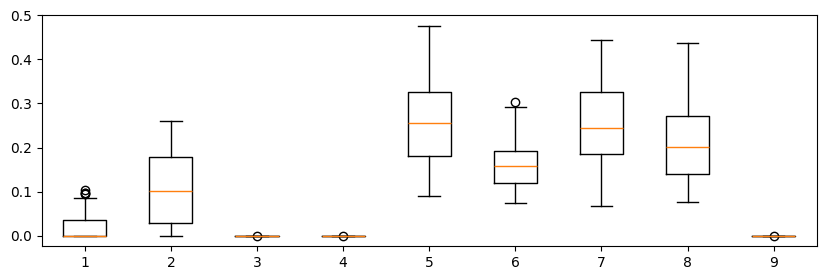

In [4]:
res_dict = {}
for i in range(300):
    init_abd, snapshot_mtx, noise_mtx = simulate_one_example(interaction_df,100,1)
    res_dict[i] = {}
    res_dict[i]["init_abd"] = init_abd
    res_dict[i]["snapshot_mtx"] = snapshot_mtx      ## (100,9)
    res_dict[i]["noise_mtx"] = noise_mtx

example = res_dict[0]['snapshot_mtx']
plot_allu(example)
plot_box(example) 

## Pick Observations

Say, we observed the abduances at the final step

In [5]:
obs_mtx = np.array([res_dict[tests_idx]['snapshot_mtx'][-1] for tests_idx in res_dict.keys()])
obs_mtx.shape

(300, 9)

## See Correlation

30 repeats:  seems not very correct, even for the signs

300 repeats: seems ok for signs

In [6]:
coor = np.corrcoef(obs_mtx.T)  ## (9,9)
coor_df = pd.DataFrame(coor,index=bac_names,columns=bac_names)
coor_df

,bac1,bac2,bac3,bac4,bac5,bac6,bac7,bac8,bac9
bac1,1.000000,0.271106,-0.186581,-0.131009,-0.064905,-0.233862,-0.193352,-0.221861,-0.015960
bac2,0.271106,1.000000,-0.340671,-0.233377,0.118890,-0.406427,-0.177122,-0.346797,0.142568
bac3,-0.186581,-0.340671,1.000000,0.088990,-0.245439,-0.110063,0.187242,0.021669,-0.053822
bac4,-0.131009,-0.233377,0.088990,1.000000,-0.201846,0.093879,-0.416490,0.149483,-0.114107
bac5,-0.064905,0.118890,-0.245439,-0.201846,1.000000,-0.402331,-0.184726,-0.027996,0.049395
bac6,-0.233862,-0.406427,-0.110063,0.093879,-0.402331,1.000000,-0.123098,-0.137204,-0.171347
bac7,-0.193352,-0.177122,0.187242,-0.416490,-0.184726,-0.123098,1.000000,-0.287363,0.070260
bac8,-0.221861,-0.346797,0.021669,0.149483,-0.027996,-0.137204,-0.287363,1.000000,-0.138675
bac9,-0.015960,0.142568,-0.053822,-0.114107,0.049395,-0.171347,0.070260,-0.138675,1.000000


0.7777777777777778

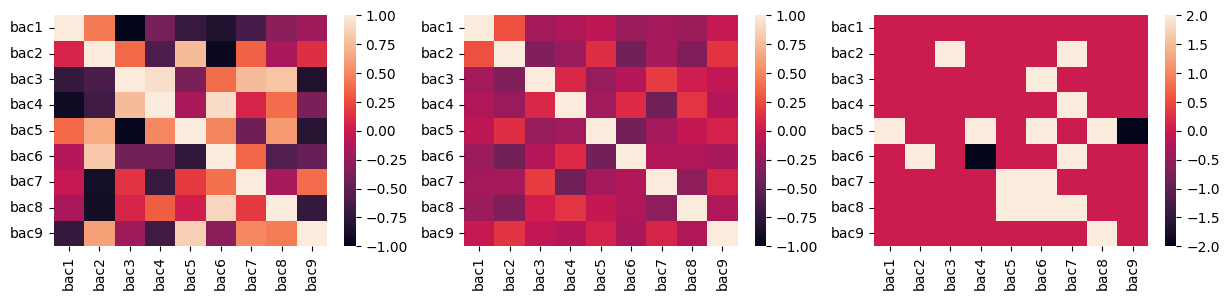

In [7]:
tsh = 0
sign_compare_df = interaction_df.map(lambda x: 1 if x>tsh else (-1 if x<-tsh else 0) ) - coor_df.map(lambda x: 1 if x>tsh else (-1 if x<-tsh else 0) )

plt.figure(figsize=(15,3))
sns.heatmap(interaction_df,vmax=1,vmin=-1,ax=plt.subplot(131))
sns.heatmap(coor_df,vmax=1,vmin=-1,ax=plt.subplot(132))
sns.heatmap(sign_compare_df,vmax=2,vmin=-2,ax=plt.subplot(133))
(sign_compare_df == 0).sum().sum() / (n*n)  ## sign acc

## Try recover interactions

Knowing: Abduance of each bac at some timestep (our observed data)

Assume: Bacs are in sbtle balance      
Assume: (ABC) on X == (DEFG) on X   ---- its not working, at least the aggr is not simply sum? or perhaps many combinations to reach stable?       
Assume: A on X != X on A     

iterate until stable (loss stop decrease)

In [8]:
inter = torch.ones(9,9,requires_grad=True)     ## i on j
# abd = obs_mtx.mean(axis=0) ## obs_mtx[1,:]
# abd = torch.tensor(abd)

def i_on_x(abd,inter,i_list,x):
    return (abd[i_list] * inter[i_list,x]).sum()


def x_loss(abd,inter,x):
    remain = list(range(n))
    remain.remove(x)
    random.shuffle(remain)
    half_idx = np.random.randint(n-1-1)
    i_list = remain[:half_idx]
    j_list = remain[half_idx:]
    return torch.abs(i_on_x(abd,inter,i_list,x) - i_on_x(abd,inter,j_list,x))


def total_loss(abd,inter):
    L = 0
    for x in range(n):
        L += x_loss(abd,inter,x)
    return L


lr = 1e-3
loss_record = []
for epoch in range(300): 
    loss = sum([total_loss(torch.tensor(obs_mtx[i]),inter) for i in range(n)])
    loss.backward()
    with torch.no_grad():
        inter.data -= inter.grad.data * lr
        loss_record.append(loss.item())
        if loss == min(loss_record):
            inter_at_min_loss = inter.detach().numpy()
    inter.grad.data.zero_()

inter_df = pd.DataFrame(inter_at_min_loss,index=bac_names,columns=bac_names)

0.5308641975308642

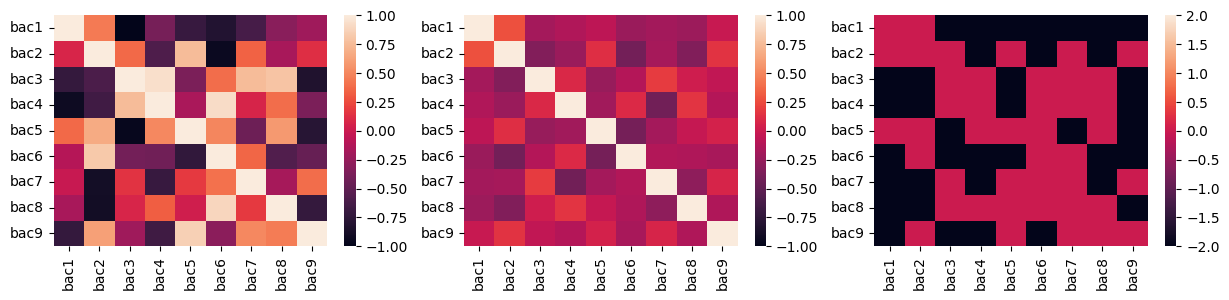

In [9]:
tsh = 0
sign_compare_df = interaction_df.map(lambda x: 1 if x>tsh else (-1 if x<-tsh else 0) ) - inter_df.map(lambda x: 1 if x>tsh else (-1 if x<-tsh else 0) )

plt.figure(figsize=(15,3))
sns.heatmap(interaction_df,vmax=1,vmin=-1,ax=plt.subplot(131))
sns.heatmap(coor_df,vmax=1,vmin=-1,ax=plt.subplot(132))
sns.heatmap(sign_compare_df,vmax=2,vmin=-2,ax=plt.subplot(133))
(sign_compare_df == 0).sum().sum() / (n*n)  ## sign acc

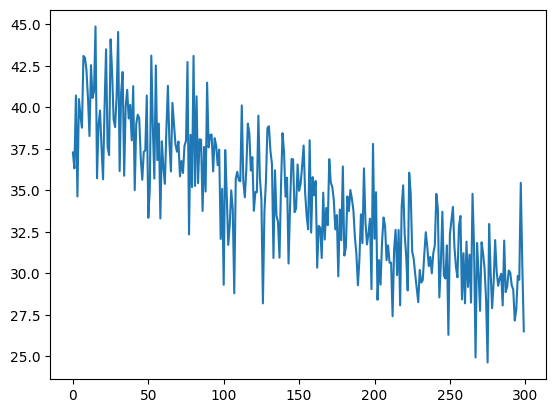

In [10]:
plt.plot(loss_record)

In [11]:
## loss for true interaction..

sum([total_loss(torch.tensor(obs_mtx[i]),   torch.tensor(interaction_df.values)        ) for i in range(n)])

tensor(15.2197, dtype=torch.float64)

## Simulate using predicted interactions

seems predicted links performs better than r?

ToDo: compare ranks of each bac

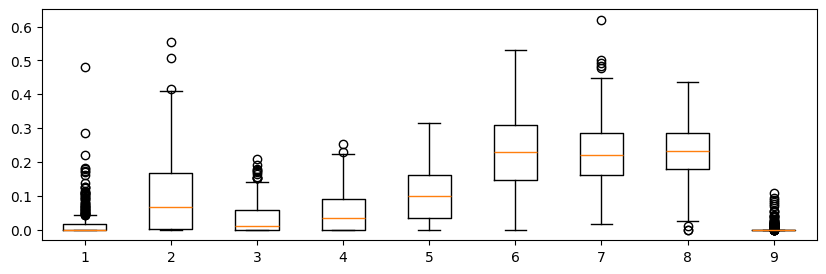

In [12]:
mean_mtx = np.array([res_dict[key]['snapshot_mtx'].mean(axis=0) for key in res_dict.keys()])  ## using original
plot_box(mean_mtx)  

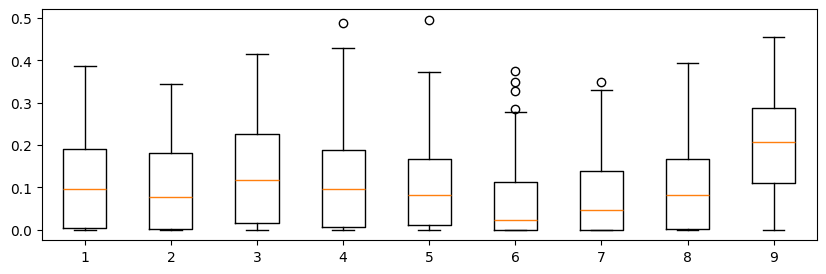

In [13]:
res_dict = {}
for i in range(300):
    init_abd, snapshot_mtx, noise_mtx = simulate_one_example(coor_df,100,1)        ## Using r
    res_dict[i] = {}
    res_dict[i]["init_abd"] = init_abd
    res_dict[i]["snapshot_mtx"] = snapshot_mtx      ## (100,9)
    res_dict[i]["noise_mtx"] = noise_mtx

mean_mtx = np.array([res_dict[key]['snapshot_mtx'].mean(axis=0) for key in res_dict.keys()])
plot_box(mean_mtx)  

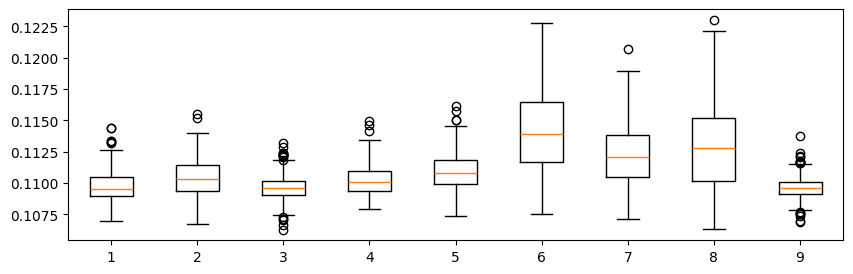

In [14]:
res_dict = {}
for i in range(300):
    init_abd, snapshot_mtx, noise_mtx = simulate_one_example(inter_df,100,1)        ## Using predicted links
    res_dict[i] = {}
    res_dict[i]["init_abd"] = init_abd
    res_dict[i]["snapshot_mtx"] = snapshot_mtx      ## (100,9)
    res_dict[i]["noise_mtx"] = noise_mtx

mean_mtx = np.array([res_dict[key]['snapshot_mtx'].mean(axis=0) for key in res_dict.keys()])
plot_box(mean_mtx)  